# Jupyter intro

### Useful shortcuts:
- Shift + Tab - function tooltip
- Shift + Tab + Tab - more detailed function info
- Tab - autocomplete list
- Shift + Enter - run cell

# Pandas intro

### Load all libraries needed

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn # for prettier plots, probably need to install it => conda install seaborn
%matplotlib inline

c:\python35\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Load datasets
All datasets are complete, there is no holes in them. Time represents number of hours from 2005-01-01.

In [73]:
with open('weather.pickle', 'rb') as file:
    weather = pickle.load(file)
with open('smog.pickle', 'rb') as file:
    smog = pickle.load(file)
    # smog -> dictionary, key is station number as string ex.
    # smog['6']['data']

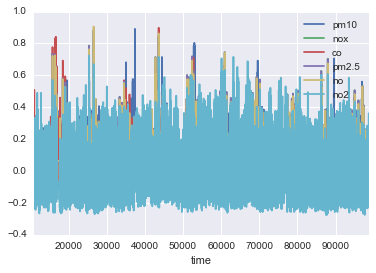

In [3]:
smog['6']['data'].plot(x='time')

#### About normalization
Datasets are also normalized.
To convert data back to original form use:
$$o = d \cdot (o_{max} - o_{min}) + o_{mean}$$
```python
# Ex.
smog_origin = smog[STATION]['data'] * (smog[STATION]['max'] - smog[STATION]['min']) + smog[STATION]['mean']
```

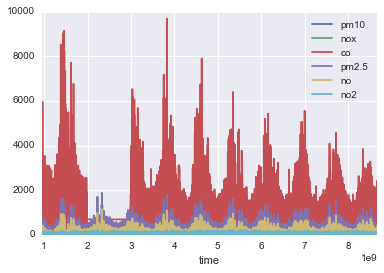

In [4]:
smog_origin = smog['6']['data'] * (smog['6']['max'] - smog['6']['min']) + smog['6']['mean']
smog_origin.plot(x='time')

### Useful functions for unnormalizing data

In [5]:
def unnormalize(x, min_value, max_value, mean_value):
    return x * (max_value - min_value) + mean_value

In [6]:
def unnormalize_smog(x, station, substance):
    return unnormalize(x, smog[station]['min'][substance], smog[station]['max'][substance], smog[station]['mean'][substance])

In [7]:
def unnormalize_weather(x, what):
    return unnormalize(x, weather['min'][what], weather['max'][what], weather['mean'][what])

### For converting `time` column

In [8]:
def hours_to_date(x):
    base_time = pd.to_datetime('2005-01-01').to_datetime64().astype('int64')
    return pd.to_datetime(base_time // 1000000000 + x * 3600, unit='s')

In [9]:
def date_to_hours(date):
    if type(date) == type(''):
        date = pd.to_datetime(date)
    base_date = pd.to_datetime('2005-01-01').to_datetime64().astype('int64')
    return int((date.to_datetime64().astype('int64') - base_date) // 3600000000000)

# Scikit learn - Regression

In [10]:
from sklearn import linear_model

# Actual work
We will work on `weather_smog` dataset, but first we need to split it on train, validation, test sets. We will always train our model on train set then try to evaluate it on validation set and fine-tune hyper-parameters. At the very end we will check our model on test set.

In [74]:
weather_smog = pd.merge(weather['data'], smog['7']['data'], on='time') # for now we only use station 7
weather_data = weather['data'].copy()
smog_data = smog['7']['data'].copy()

In [12]:
def create_and_fit_model(X, y):
    model = linear_model.LinearRegression(n_jobs=8)
    model.fit(X, y)
    return model

In [13]:
def plot_fitted_data(model, X, y, begin=0, end=100, station='7', substance='co'):
    prediction = model.predict(X)
    plt.figure(figsize=(16, 9))
    tmp = X[:]
    tmp['target'] = y
    tmp['pred'] = prediction
    tmp = tmp.sort_values(by='time')
    plt.plot(tmp['time'][begin:end], unnormalize_smog(tmp['target'], station, substance)[begin:end])
    plt.plot(tmp['time'][begin:end], unnormalize_smog(tmp['pred'], station, substance)[begin:end])
    plt.show()

In [14]:
def plot_dependency(model, feature_list):
    index = np.arange(len(feature_list))
    bar_width = 0.35
    plt.figure(figsize=(16, 9))
    plt.bar(index, model.coef_, bar_width)
    plt.xticks(index + bar_width / 2, feature_list)
    plt.tight_layout()
    plt.show()

# Model for PM10 only

In [174]:
subst_data = smog_data[['time', 'pm10']]
subst_data.head()

,time,pm10
0,10920,-0.022999
1,10921,-0.040390
2,10922,-0.070825
3,10923,-0.072274
4,10924,-0.065028


## Prepare targets for all data

In [175]:
def split_time_column(data):
    dates = data['time'].apply(hours_to_date)
    data['hour'] = dates.apply(lambda x: x.hour)
    data['weekday'] = dates.apply(lambda x: x.dayofweek)
    data['monthday'] = dates.apply(lambda x: x.day)
    data['weekyear'] = dates.apply(lambda x: x.weekofyear)
    data['dayyear'] = dates.apply(lambda x: x.dayofyear)
    data['month'] = dates.apply(lambda x: x.month)
    return data

In [176]:
subst = split_time_column(subst_data)

c:\python35\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
c:\python35\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\python35\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus

In [177]:
# subst = subst.drop('time', 1)

In [178]:
subst.head()

,time,pm10,hour,weekday,monthday,weekyear,dayyear,month
0,10920,-0.022999,0,5,1,13,91,4
1,10921,-0.040390,1,5,1,13,91,4
2,10922,-0.070825,2,5,1,13,91,4
3,10923,-0.072274,3,5,1,13,91,4
4,10924,-0.065028,4,5,1,13,91,4


## Add weather features

In [179]:
# weather_data['time'] -= 24

In [180]:
print(weather_data['time'][0])
print(weather['data']['time'][0])

57436
57460


In [181]:
subst_weather = pd.merge(subst, weather_data, on='time')
subst_weather = subst_weather[subst_weather['time'] >= 57500]

In [182]:
len(subst_weather)

41212

In [183]:
target_subst = 'pm10'
subst_weather['target'] = subst_weather[target_subst]
subst_weather['target'][:-1] = subst_weather['target'][1:]

subst_weather = subst_weather[subst_weather['time'] >= 57500][:40000]
subst_weather.head()

c:\python35\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,time,pm10,hour,weekday,monthday,weekyear,dayyear,month,wind-direction,humidity,pressure,wind-speed,rain,temperature,target
64,57500,-0.044738,20,6,24,29,205,7,0.099004,0.320546,-0.102237,-0.050155,0.158041,0.074555,-0.037492
65,57501,-0.037492,21,6,24,29,205,7,0.117022,0.320922,-0.096972,-0.051891,0.159719,0.070905,-0.036042
66,57502,-0.036042,22,6,24,29,205,7,0.135040,0.314530,-0.092609,-0.053627,0.159719,0.070384,-0.038941
67,57503,-0.038941,23,6,24,29,205,7,0.192097,0.311396,-0.089751,-0.078801,0.159719,0.072121,-0.021550
68,57504,-0.021550,0,0,25,30,206,7,0.201106,0.316660,-0.085839,-0.074027,0.159719,0.073164,-0.024448


In [184]:
subst_weather = subst_weather.drop('time', 1)

In [185]:
subst_weather.head()

,pm10,hour,weekday,monthday,weekyear,dayyear,month,wind-direction,humidity,pressure,wind-speed,rain,temperature,target
64,-0.044738,20,6,24,29,205,7,0.099004,0.320546,-0.102237,-0.050155,0.158041,0.074555,-0.037492
65,-0.037492,21,6,24,29,205,7,0.117022,0.320922,-0.096972,-0.051891,0.159719,0.070905,-0.036042
66,-0.036042,22,6,24,29,205,7,0.135040,0.314530,-0.092609,-0.053627,0.159719,0.070384,-0.038941
67,-0.038941,23,6,24,29,205,7,0.192097,0.311396,-0.089751,-0.078801,0.159719,0.072121,-0.021550
68,-0.021550,0,0,25,30,206,7,0.201106,0.316660,-0.085839,-0.074027,0.159719,0.073164,-0.024448


## Add new features here

In [186]:
# new features
features = list(subst_weather.columns)
features.remove('target')
print(features)

['pm10', 'hour', 'weekday', 'monthday', 'weekyear', 'dayyear', 'month', 'wind-direction', 'humidity', 'pressure', 'wind-speed', 'rain', 'temperature']


## Split dataset

In [187]:
def split_data(data, size, rnd=42):
    np.random.seed(rnd)
    dataset = data.reindex(np.random.permutation(data.index))
    length = int(len(data) * size)
    return dataset[:length], dataset[length:]

In [188]:
train, valid_test = split_data(subst_weather, 0.6)
valid, test = split_data(valid_test, 0.5)
print("Train size:", len(train))
print("Valid size:", len(valid))
print("Test  size:", len(test))

Train size: 24000
Valid size: 8000
Test  size: 8000


## Make model for all labels

In [189]:
def make_model_for_label(data, features, target):
    return create_and_fit_model(np.array(data[features]), np.array(data[target + '-target']))

In [190]:
model = create_and_fit_model(train[features], train['target'])

In [191]:
for feature, coef in zip(features, model.coef_):
    print('%-15s: % 2.5f' % (feature, coef))

pm10           :  0.85746
hour           :  0.00049
weekday        :  0.00006
monthday       : -0.00103
weekyear       :  0.00004
dayyear        :  0.00103
month          : -0.03133
wind-direction : -0.00151
humidity       :  0.00057
pressure       :  0.00071
wind-speed     : -0.01824
rain           : -0.01745
temperature    : -0.02246


## Evaluate model on validation set

In [192]:
print('pm10:', model.score(valid[features], valid['target']))

pm10: 0.787046636731


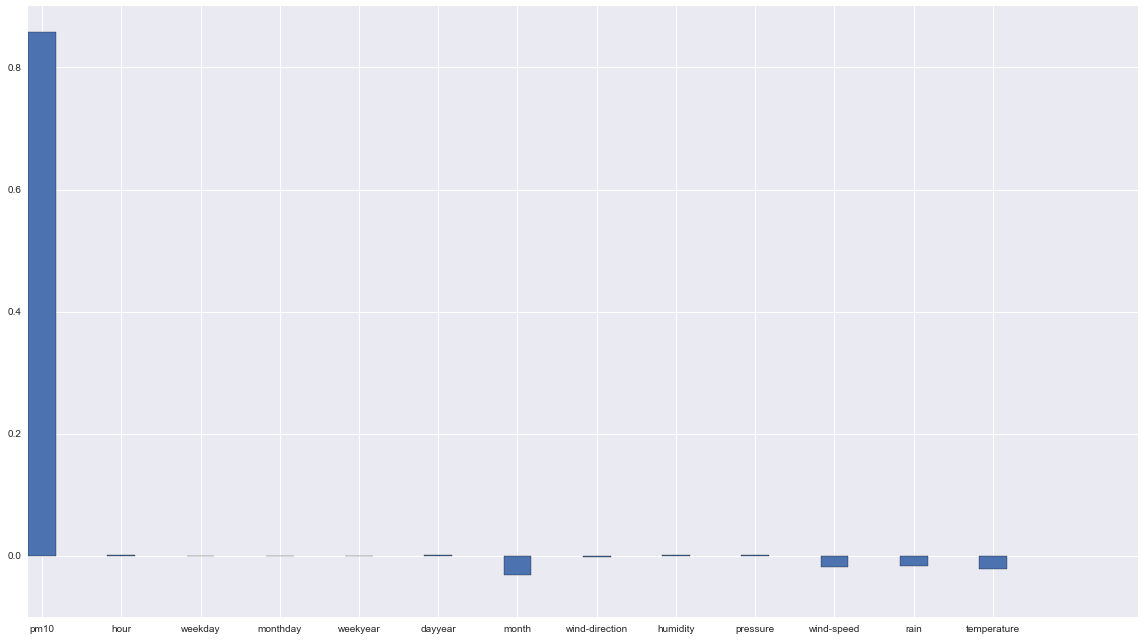

In [193]:
plot_dependency(model, features)

## Check the previous day prediction model

In [211]:
previous_day_model = create_and_fit_model(np.array(train['pm10']).reshape((-1, 1)), np.array(train['target']))

In [212]:
previous_day_model.coef_

array([ 0.88313263])

In [213]:
print('Score:', previous_day_model.score(np.array(valid['pm10']).reshape((-1, 1)), np.array(valid['target'])))

Score: 0.782474685549
